In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [2]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import random

np.random.seed(0)

Using TensorFlow backend.


In [4]:
# pickling - byte stream (of a python object/array) into an array
# unpickling - an array/object/other python data struct into a byte stream

# parsing the data into something useable
# (2) rb - to read in binary format
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)
  
print(type(train_data))

# train_data('features'), train_d

<class 'dict'>


In [5]:
# some look-see on the items

train_data.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [6]:
train_data['labels']

array([41, 41, 41, ..., 25, 25, 25], dtype=uint8)

In [0]:
# mapping them correctly

X_train = train_data['features']
y_train = train_data['labels']

X_val = val_data['features']
y_val = val_data['labels']

X_test = test_data['features']
y_test = test_data['labels']

In [8]:
# check
# check the pixel sizes as well of the images

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
# error checks (auto tests)
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."

assert(X_train.shape[1:] == (32,32, 3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[1:] == (32,32, 3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[1:] == (32,32, 3)), "The dimensions of the images are not 32 x 32 x 3."


In [10]:
data = pd.read_csv('german-traffic-signs/signnames.csv') # see the ls for this file
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


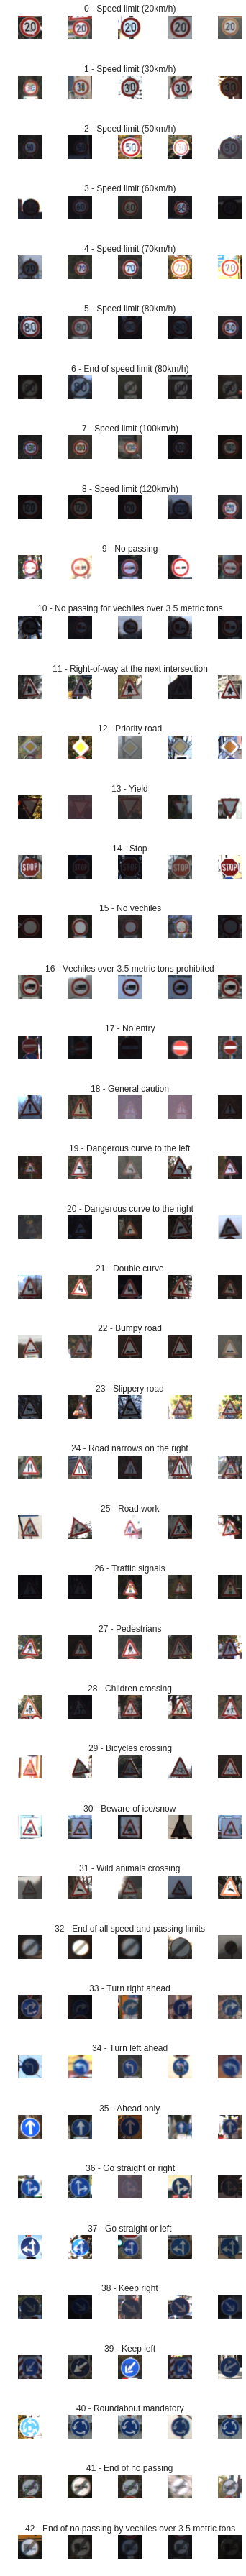

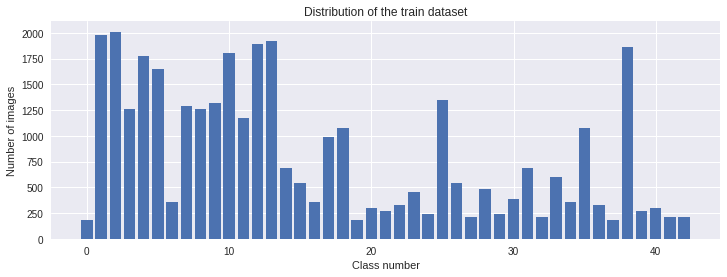

In [11]:
num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

# taking a look at the images
for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))
        
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


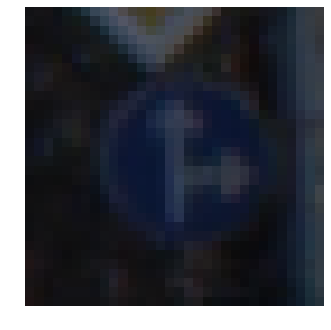

In [12]:
import cv2
 
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


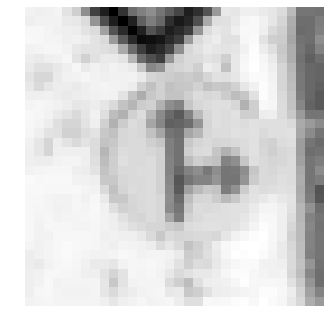

In [13]:
# 
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img
  
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


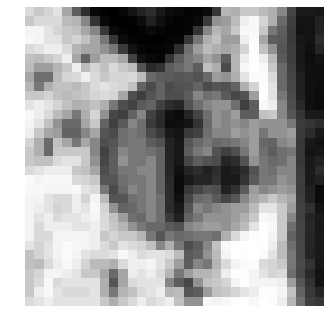

In [14]:
# equalizeHist standardizes the lighting effect in the images
# basically it takes each pixel, plops their color value (gray color value) into a histogram and "stretches" it out
# the result is the same image but with less higher values and more color all over the place
# it evens out the brightness so the inages will be more similar and not dependent on brightness
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
  
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

(34799, 32, 32)


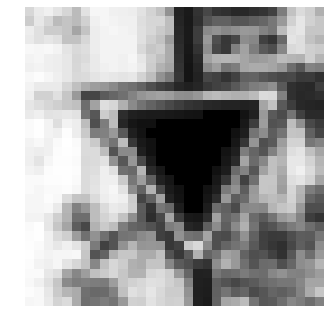

In [15]:
# grayscale and equalize `em
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img
  
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [0]:
# flatten out each image's array

X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)


In [0]:
# define the leNet_model function
def leNet_model():
    model = Sequential()
    # adding the convolution layer
    # (1) number of epochs
    # (2) kernel size
    # (3) image size 32 px x 32 px with 1 channel aka 1 color
    # (4) activation function type
    model.add(Conv2D(
        30, 
        (5, 5), 
        input_shape=(32, 32, 1), 
        activation="relu"
    ))
    
    # adding the pooling layer
    # for details on what maxpooling does...
    # see: https://github.com/steven4354/cifar-10-img-classifier/blob/master/cifar_image_classifier.ipynb
    model.add(MaxPooling2D(
        pool_size=(2,2)
    ))
    
    model.add(Conv2D(15, (3,3), activation="relu"))
    
    model.add(MaxPooling2D(
        pool_size=(2,2)
    ))
    
    
    # flatten the pics
    # each img will now be an 1D array
    model.add(Flatten())
    
    # (1) is the number
    model.add(Dense(500, activation="relu"))
    
    # what the dropout layer does: https://www.quora.com/In-Keras-what-is-a-dense-and-a-dropout-layer
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation="softmax"))
    
    model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
model = leNet_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 30)        780       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 15)        4065      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 15)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 540)               0         
_________________________________________________________________
dense_1 (Dense)      

In [27]:
model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=400, verbose=1, shuffle=1)
# print(X_train.shape)
# print(y_train.shape)

'''
TODO: fix the data input issue here
  
  ValueError                                Traceback (most recent call last)
<ipython-input-27-af2600453d6e> in <module>()
----> 1 model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=400, verbose=1, shuffle=1)
      2 # print(X_train.shape)
      3 # print(y_train.shape)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py in fit(self, x, y, batch_size, epochs, verbose, callbacks, validation_split, validation_data, shuffle, class_weight, sample_weight, initial_epoch, steps_per_epoch, validation_steps, **kwargs)
    950             sample_weight=sample_weight,
    951             class_weight=class_weight,
--> 952             batch_size=batch_size)
    953         # Prepare validation data.
    954         do_validation = False

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py in _standardize_user_data(self, x, y, sample_weight, class_weight, check_array_lengths, batch_size)
    787                 feed_output_shapes,
    788                 check_batch_axis=False,  # Don't enforce the batch size.
--> 789                 exception_prefix='target')
    790 
    791             # Generate sample-wise weight values given the `sample_weight` and

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py in standardize_input_data(data, names, shapes, check_batch_axis, exception_prefix)
    136                             ': expected ' + names[i] + ' to have shape ' +
    137                             str(shape) + ' but got array with shape ' +
--> 138                             str(data_shape))
    139     return data
    140 

ValueError: Error when checking target: expected dense_2 to have shape (43,) but got array with shape (1,)
'''

ValueError: ignored